In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image
import pandas as pd


#### Review of lecture 17

In lecture 17 we:


- learned some statistical tests: t-test, F-test

- learned some non-parametric approaches to statistical testing (bootstrap, jackknife).  



#### In this lecture we will:

- Apply some of the principles that we learned in Lecture 16 and 17 to real data

- Learn about skewness and kurtosis of distributions

- Learn how to make cool 'heat maps' for data.  

### "Real" empirical data

In the last two lectures we simulated data using Monte Carlo techniques and learned a few techniques for hypothesis testing.  But there are oodles of "real" data that we can look at.  Let's say we have a bunch of measurements of grain size from marine sediment cores.  There was a paper by our own Professor Dick Norris (Hull et al., 2011; http://dx.doi.org/10.1038/NGEO1302) in which the authors presented a lot of grain size data as a function of depth (age) in a core.    

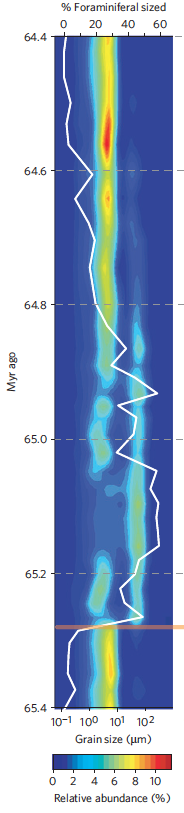

In [4]:
Image(filename='Figures/grainSize.png')

_[Figure from Hull et al., 2011.] _

This figure plots abundance data  as color bars with higher abundances in warmer colors instead of as histograms.   The brown line is the Cretaceous/Paleogene boundary; what happened then??? 

The white line is the percentage of plantktonic foraminiferal sized grains.  These are defined as being  anything bigger than about 20 $\mu$m.  



Let's read in the data and take a look.  I put a small subset of the data in the Datasets/grainSize directory, so let's look at that first.   

In [5]:
gs=pd.read_csv('Datasets/grainSize/Site1209-KPg-Grainsize_edit.csv',header=0) # read into a DataFrame
gs.columns

Index(['size_um', '64.5613', '64.6055', '64.6418', '64.6781', '65.349',
       '65.3731', '65.4032', '65.4333', '65.4634', '65.48', '65.5402',
       '65.6005', '65.6607', '65.721', '65.7812', '65.8414', '65.9017',
       '65.9619', '65.986', '66.0463'],
      dtype='object')

The column headers are the ages in Ma, except the first column, which is the grain size bin in microns. 

But first an aside about how sedimentologists think.  They prefer the use of $\phi$ instead of grain size.  $\phi$  which is related to grain size by: 

$\phi = -log_2 D$, were $D$ is the grain size in mm.  

Here is a helpful guide to understanding sedimentological
grain size scales:  

$\phi$ scale | Size range | Wentworth class | Other names
------------|-----------|--------------|---------------
<−8 | >256 mm | Boulder |
−6 to −8 | 64–256 mm | Cobble | 
−5 to −6 | 32–64 mm | Very coarse gravel | Pebble
−4 to −5 | 16–32 mm | Coarse gravel | Pebble
−3 to −4 | 8–16 mm | Medium gravel | Pebble
−2 to −3 | 4–8 mm | Fine gravel | Pebble
−1 to −2 | 2–4 mm | Very fine gravel | Granule  
0 to −1 | 1–2 mm | Very coarse sand |   
1 to 0 | 0.5–1 mm | Coarse sand | 
2 to 1 | 0.25–0.5 mm | Medium sand |    
3 to 2 | 125–250 µm | Fine sand |       
4 to 3 | 62.5–125 µm | Very fine sand | 
8 to 4 | 3.9–62.5 µm | Silt | Mud
10 to 8 | 0.98–3.9 µm | Clay | Mud
20 to 10 | 0.95–977 nm | Colloid | Mud



So, we would like to plot the grain size data (in units of $\phi$) sequentially versus age.  But there are a few housekeeping chores we have: 
- The ages are not in order in the column header list. This is because the data came from different cores and were pieced together later by mapping each core's depth coordinates onto a master 'composite depth'.  So in order to plot them in numerical age order, we need to convert the list of ages to float from a string, sort the list, then call the data for each age in turn.  
- The grain sizes are in microns, not phi, so we  have to  convert them to millimeters (from microns)  and then to $\phi$.  
- We would love to calculate the skewness and kurtosis (two statistics on distribution that sedimentologists love)  on these data and put them on the plots.  

Let's do these housekeeping chores first.  


In [6]:
# make a list of the ages (skipping the first column which is grain size)
ages=gs.columns.tolist()[1:-1] # fish out the ages from the column headers - remember this from many lectures ago!
new_ages=[float(x) for x in ages] # turn the ages list into floats (from strings) - remember list comprehension!
ages=sorted(new_ages) # sort the ages
ages=[str(x) for x in ages] # turn them back into strings (for the column headers)
print (ages) # to make sure this happened correctly. 

# now cast grain sizes as phi
gs['size_mm']=gs['size_um']*1e3 # convert the sizes to mm from microns
gs['size_phi']=np.log2(gs['size_mm']) # [put in a phi scale]


['64.5613', '64.6055', '64.6418', '64.6781', '65.349', '65.3731', '65.4032', '65.4333', '65.4634', '65.48', '65.5402', '65.6005', '65.6607', '65.721', '65.7812', '65.8414', '65.9017', '65.9619', '65.986']


And one more thing.    Along with the median value, there are other useful  ways of characterizing the shape and spread of the distributions, particularly popular with non-normal distributions (like grain size data): _skewness_ and _kurtosis_.  So we might as well define them here.  

The _skewness_ is defined as "a measure of the degree of asymmetry of a distribution". If the left tail (tail at small end of the distribution) is more pronounced than the right tail (tail at the large end of the distribution), the function is said to have negative skewness. If the reverse is true, it has positive skewness. If the two are equal, it has zero skewness. 

_Kurtosis_ is a measure of the "peakiness" of the data relative to a normal distribution.  If the kurtosis is less than 3, the distribution is more peaked than a normal distribution; if it is greater than 3, then it is less peaked.  

Both of these can be readily calculated with the **scipy.stats** module but also, using **Pandas**.  Skewness is calculated with **Series.skew( )** and kurtosis with **Series.kurt( )**.  



 

Now we are ready to make some plots.  Because we will want to do  some tricky things like suppress axis labels and the like, we should use the **add_subplot( )**  trick we learned before. Remember that  **plt.add_subplot(rows,columns,plot_number)** has the number of rows (=number of ages), number of columns (1) and the number of the particular plot (plot_number) specified.  We can use the length of the **ages** list for the number of rows and make a counter (**plot_number**) to keep track of the plot number.  

Also, I want to show you how to practice nameing the subplot object (here called **ax**) and use the methods of a subplot class to customize the tick marks on the x axis.  

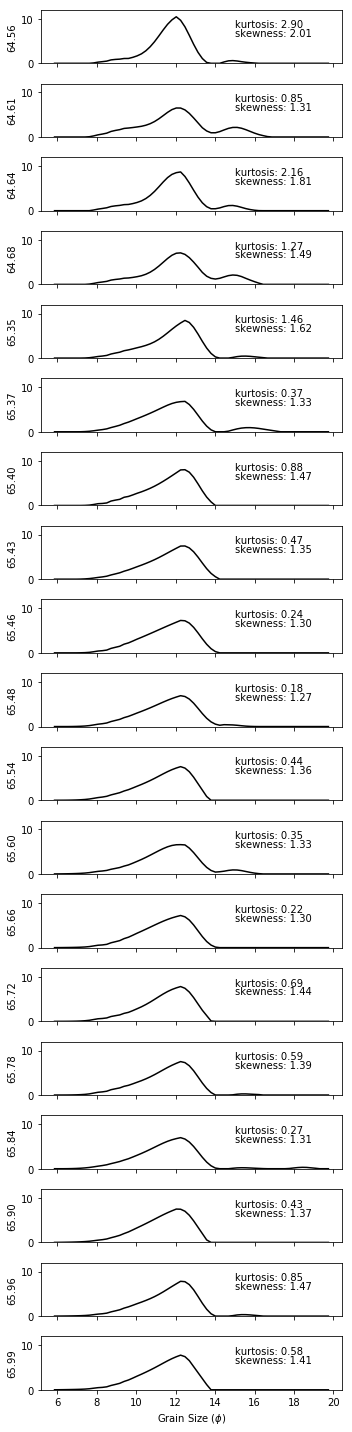

In [7]:
rows=len(ages) # set number of rows here. 
fig=plt.figure(1,(5,20)) # set up a figure that is tall (20) and skinny (5)
plot_number=1 # make a plot counter, starting with 1
for age in ages: # step through the ages from youngest (at the top) to oldest (at the bottom)
    skew=gs[age].skew() # calculate skewness of the data for this age. 
    kurt=gs[age].kurt() # calculate kurtosis
    ax=fig.add_subplot(rows,1,plot_number) # make an ax instance (useful for controlling ticks)
    plt.plot(gs['size_phi'],gs[age],'k-') # plot the data for this age
    plt.ylabel('%5.2f'%(float(age))) # label the Y axis with the age, formatted
    plt.text(15,8,'kurtosis: %4.2f'%(kurt)) # put on kurtosis as note
    plt.text(15,6,'skewness: %4.2f'%(skew)) # put on skewness as note
    
# make a dictionary with some specifics for the tick labels, customized for this plot
    ax.tick_params(   # turn off Xtick labels  for first  plots
        axis='x',          # changes apply to the x-axis
        labelbottom='off') # labels along the bottom edge are off
    plot_number+=1 # increment plot number
    plt.ylim(0,12) # make all plots have same y axis dimensions
ax.tick_params(   # turn on Xtick labels  for last  plot
    axis='x',          # changes apply to the x-axis
    labelbottom='on') # labels along the bottom edge are off
plt.xlabel('Grain Size ($\phi$)') # labels the X label of the last plot
plt.ylim(0,12); # make all plots have same y axis dimensions
plt.tight_layout() # scootches all the plots closer together.  



So, most of the data in the bottom (oldest) plots show a single distribution of skewed data (long tail to the coarser (lower $\phi$) numbers.  Both skewness and kurtosis seem to be higher in the younger data sets.  Hmm.  Also there are two 'humps' in some of the younger data sets.   

Now let's try to re-create the figure from Hull et al. (2011), because it is beautiful and also because it shows some very strange behavior right at the Cretaceous/Paleogene boundary.   

So, we will read in the whole data file now and process it as follows: 

- We will read in the ages, and sort them pretty much as before.  
- But, we want to sort the whole DataFrame now so we can plot it in "one go". 
- To do this, it  will be handy to transpose the DataFrame so that the ages are the rows and all the grain size data are on each column.  
- Then we will plot the data using **plt.imshow( )** which is a way to make those 'heat maps' whereby larger abundances are plotted as warmer colors instead of as squiggly lines. 

Let's start with the first few tasks (re-ordering the columns, then transposing the DataFrame).

In [9]:
gs=pd.read_csv('Datasets/grainSize/Site1209-KPg-Grainsize.csv',header=0) # read into a DataFrame
print ('Original structure:')
print (gs.columns) # look at what we have
gs.set_index(['size_um'],inplace=True) # move the column header 'size_um' to be the index. 
print ('New structure:')
print (gs.columns) # look at what we just did


Original structure:
Index(['size_um', '65.13744218', '65.15866667', '65.17989116', '65.20111565',
       '65.22234014', '65.24356463', '65.26478912', '65.28512048',
       '65.30319277',
       ...
       '64.32269767', '64.33981395', '64.35693023', '64.37404651',
       '64.39972093', '64.41933333', '64.42955556', '64.43977778',
       '64.50018182', '64.52527273'],
      dtype='object', length=154)
New structure:
Index(['65.13744218', '65.15866667', '65.17989116', '65.20111565',
       '65.22234014', '65.24356463', '65.26478912', '65.28512048',
       '65.30319277', '65.32126506',
       ...
       '64.32269767', '64.33981395', '64.35693023', '64.37404651',
       '64.39972093', '64.41933333', '64.42955556', '64.43977778',
       '64.50018182', '64.52527273'],
      dtype='object', length=153)


Notice how size_um disappeared as a column header.  

Now let's work on the ages:

In [10]:
# this is the same as we did before: 
ages=gs.columns.tolist()
ages=[float(i) for i in ages] # make floating point
# this is new
gs.columns=ages # reassign as column headers. 
# we can re-arrange the order of the columns this way: 
ages=sorted(ages) # sort the age list
gs=gs.reindex_axis(ages,axis=1)  # reindex the ages 
gs=gs.T # takes the transpose of the DataFrame (swaps rows and columns)
sizes=gs.columns # the columns are now the sizes in microns. 

One more thing before we let 'er rip. Making a 'heat map' like we are trying to do involves assigning colors to certain threshold levels of the data we want to plot.  This is done via a _color map_, which in **matplotlib** is controlled by the keyword argument **cmap** and the module **cm**.  So if we import **cm** from **matplotlib**, we can choose from a wide variety of color maps (see https://matplotlib.org/users/colormaps.html).  

Here we will use one called **cm.jet** which does pretty nicely for this purpose.

In [11]:
from matplotlib import cm

Now let's make the plot!  

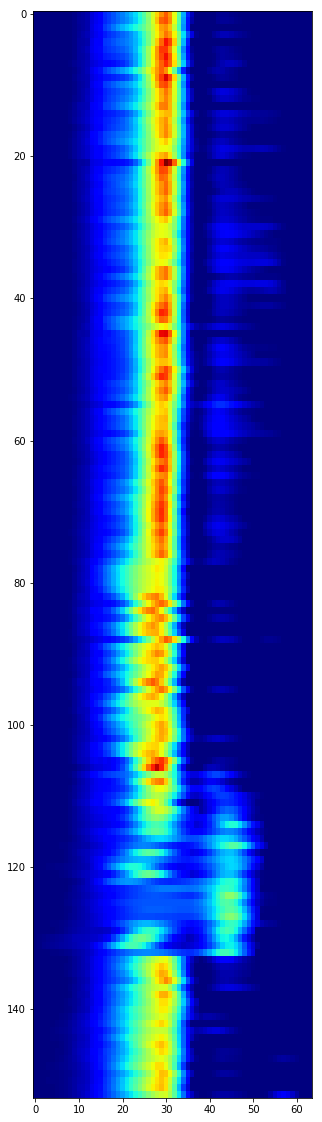

In [12]:
plt.figure(2,(5,20)) # create the plot instance
plt.imshow(gs,aspect='auto',cmap=cm.jet); # make the plot with the jet color map

Wow!  that was easy and it looks a lot like the plot we are trying to re-create!  
But, **plt.imshow( )** has a funny way of dealing with axis labels.  It uses by default the row and column numbers - not their values. So to make a nice plot, we have to supress the tick labels in this plot and draw some new ones that are in data units (ages and log microns).   

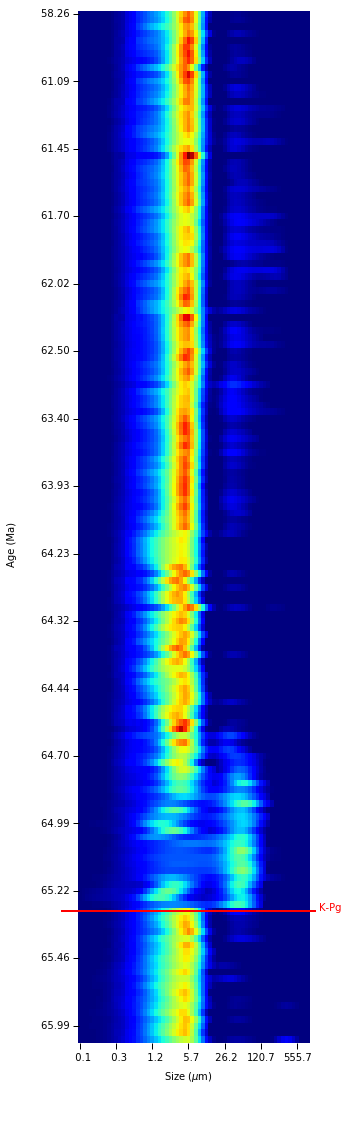

In [16]:
ytick_labels=[] # set up some lists for y tick labels
ytick_locs=[] # set up a list for the tick locations
for k in range(len(ages)): # step through the indices for age
    if k%10==0: # pick out every tenth one - remember the modulo function %
        ytick_locs.append(k) # append the tick mark index
        ytick_labels.append(ages[k]) # append the age
xs=np.ones(len(ytick_locs))*-1 # get a list of x values for the age tick marks
xtick_labels=[] # set up some lists for x labels and ticks
xtick_locs=[]
for k in range(len(sizes)): # step through the indices for grain size
    if k%10==0: # pick out every tenth one
        xtick_locs.append(k) # append the tick mark index
        xtick_labels.append(sizes[k]) # append the age
ys=np.ones(len(xtick_locs))*len(ages) # get a list of x values
# these are the same as before: 
plt.figure(3,(5,20)) # create the plot instance
plt.imshow(gs,aspect='auto',cmap=cm.jet) # make the plot

# now for the new stuff
plt.axis("off") # get rid of the axis 
plt.plot(xs,ytick_locs,'k_') # put on the y axis ticks as a column along the left side
for t in range(len(ytick_labels)): # put on the y tick labels
    # notice how they are scootched to the left
    plt.text(xs[t],ytick_locs[t],
        '%5.2f  '%(ytick_labels[t]),va='center',ha='right') 
plt.plot(xtick_locs,ys,'k|') # put on the x-axis ticks
for t in range(len(xtick_labels)): # put on the x axis labels
    plt.text(xtick_locs[t],ys[t]+1,
        '%5.1f'%(xtick_labels[t]),va='top',ha='center')
k=ages.index(65.28512048) # index closest to the K/Pg boundary
# taken as 65.28 Ma in this paper.  
plt.plot([-5,65],[k,k],'r-',linewidth=2) # put on a heavy red line
plt.text(66,k,'K-Pg',color='red') # put on a note in red. 
plt.text(xtick_locs[int(len(xtick_locs)/2)], 
         len(ages)+5,'Size ($\mu$m)',ha='center')# label the X axis
plt.text(-20,len(ages)/2,'Age (Ma)',rotation=90); # label the Y axis.

### Assignment #6
- Rename the notebook with the format Lastname_HomeworkNumber.  For example, **Asefaw_6**

6.1
- Simulate a dataset with a log normal distribution, a mean of 1, a standard deviation of .1 and a size (N) of 100 
- Plot the data using a linear X-scale
    - Calculate the mean, median, mode, skewness, and kurtosis for the distribution 
    - Plot the mean, median, and mode as vertical lines
    - Plot the skewness and kurtosis as notes on the plot
    - Include a legend
- Plot your distribution using a log X-scale (apply **np.log()** to your dataset)  
    - Calculate the mean, median, mode, skewness, and kurtosis
    - Plot the mean, median, and mode as vertical lines
    - Plot the skewness and kurtosis as notes on the plot
    - Include a legend 

6.2 
- Use the code in Lecture 18 to recreate the final figure 
    - Use the datafile:      Site1209-KPg-Grainsize.csv
- Hull et al. (2011) assumed that all grains larger than 16 $\mu$m were foraminifera. Calculate the percentagae of foraminiferal sized grains. To do this, you'll need to:
    - Filter the gs DataFrame for grain sizes larger than 16 $\mu$m
    - Calculate the percentage of foraminiferal sized grains by first calculating the sum of all the grains and then calculting the sum of all the grains larger than 16 $\mu$m
- Plot the percentage of foraminiferal sized grains as either a new plot or as a white line over the original figure 
    - If you choose the latter, use the function **twiny( )** and see this example: 
            https://matplotlib.org/examples/api/two_scales.html


Your code must be fully commented.  

Turn in your notebook on the tritoned.ucsd.edu website BEFORE the start of class next Friday

You will recieve a "zero" if the assignment is late,  copied from someone else, or not fully commented.  If the degree of copying is serious enough, you WILL be reported, so just don't do it.  

If you have trouble - contact the TA or the instructor - we are here to help!  

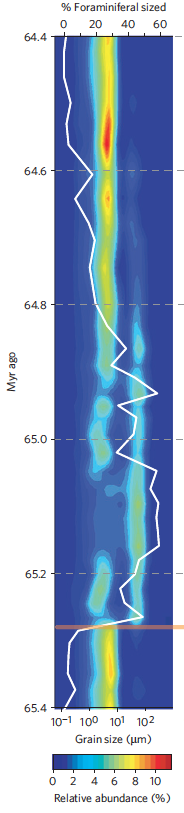

In [2]:
from IPython.display import Image
Image(filename='Figures/grainSize.png')
#In problem 6.2, you'll re-create the white line in the original figure 